# [E17]-프로젝트-Movielens 영화 SBR

## Step 0. 디렉토리 생성 및 다운로드  
  
* Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템 제작
```1) wget으로 데이터 다운로드
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

2) 다운받은 데이터를 작업디렉토리로 이동
$ mv ml-1m.zip ~/aiffel/yoochoose-data

3) 압축 해제
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip
```

* 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.  
  
* Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.  
  
* Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.  
  
* 위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', 
                       header=None, usecols=[0, 1, 2, 3], 
                       names = ['UserId', 'ItemId', 'Rating', 'Time'],
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, 
                       nrows=nrows)
    return data
data = load_data(train_path, None)
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 1. 데이터의 전처리  
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.  
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.  
  
```
$ pip list | grep pathlib
```  
위 명령어 실행해서 설치 안 되어 있으면 아래 코드로 설치  
```
$ pip install pathlib
```

### 1.1 Session Length  
각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보겠습니다.

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [6]:
user_length.min(), user_length.max()

(20, 2314)

In [7]:
user_length.quantile(0.99)

906.659999999998

In [8]:
long_session = user_length[user_length==2314].index[0]
data[data['UserId']==long_session].head(20)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
696250,4169,3841,2,2000-08-03 20:11:21
697903,4169,3761,3,2000-08-03 20:11:21
697954,4169,3788,3,2000-08-03 20:11:21
695653,4169,3794,4,2000-08-03 20:11:59


In [9]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

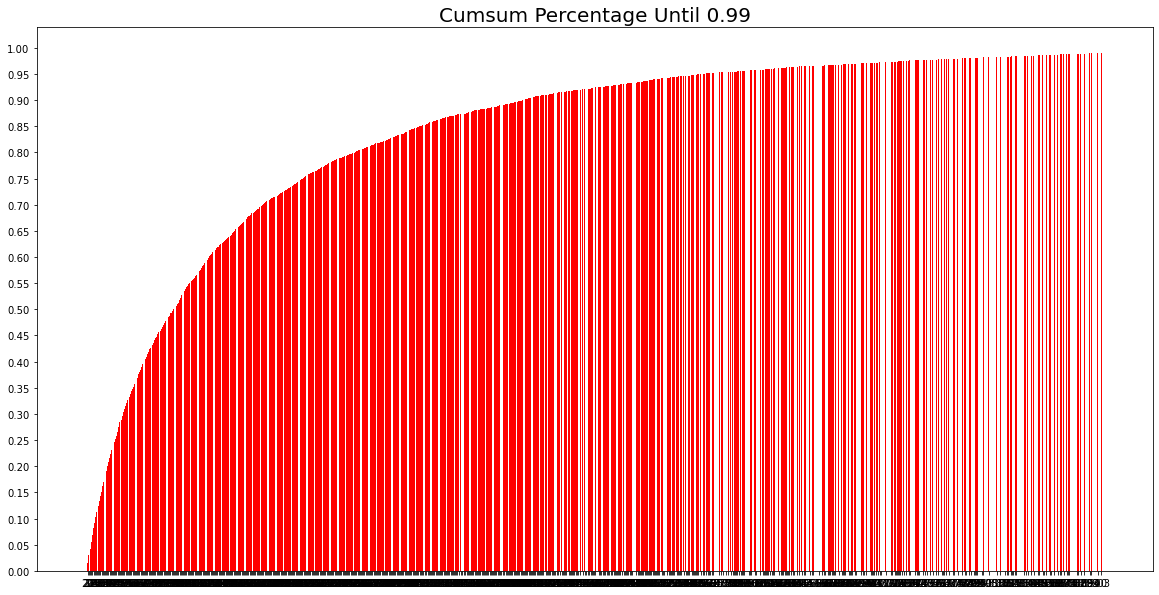

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

### 1.2 Session Time  
* 어떤 유저가 아이폰을 구매하려고 합니다. 2020년 5월에는 아이폰SE2를 구매하려는 사람이 많을 것입니다.  
* 그러나 그로부터 몇달 후면 아이폰 12의 구매량이 엄청나게 증가하게 될 것입니다.  
* 영화나 드라마 역시 마찬가지입니다. 유저들의 소비 패턴을 금방금방 변합니다.  
* 이런 이유 때문에 추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 이번에는 데이터가 발생한 시간에 대해 알아봅시다.

In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [12]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

### 1.3 Data Cleansing  
1.2에서 살펴보니 길이가 1인 세션도 꽤 있습니다. 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해줍니다.  
너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해줍니다.

In [14]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
user_len = data.groupby('UserId').size()
item_popular = data.groupby('ItemId').size()

print(user_len.mean())
print(item_popular.mean())

165.5975165562914
269.88909875876953


In [16]:
data = cleanse_recursive(data, shortest=4, least_view=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [17]:
data = data.sort_values(by=['Time'])

### 1.4 Train/ Valid/ Test split

In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [19]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978986
	 Users: 6038
	 Items: 3592
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12289
	 Users: 399
	 Items: 2624
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8820
	 Users: 339
	 Items: 2330
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [23]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

이제 데이터 준비를 마쳤습니다! 데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가겠습니다.

## Step 2. 미니 배치의 구성  
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.  
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### 2.1 SessionDataset  
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999877,6040,1419,3,2000-04-25 23:07:36,5
999868,6040,573,4,2000-04-25 23:07:36,6
999980,6040,3505,4,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999920,6040,213,5,2000-04-25 23:07:36,9


In [26]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978522, 978645, 978986], dtype=int32)

In [27]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

### 2.2 SessionDataLoader  
파이썬 문법 중 iterator, generator에 대한 좀더 친절한 안내가 필요하신 분은 이 자료를 먼저 보시길 권장합니다.  
  
`SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.  
`__iter__` 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield`합니다.  
mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head

<bound method NDFrame.head of          UserId  ItemId  Rating                Time  item_idx
1000138    6040     858       4 2000-04-25 23:05:32         0
999873     6040     593       5 2000-04-25 23:05:54         1
1000153    6040    2384       4 2000-04-25 23:05:54         2
1000007    6040    1961       4 2000-04-25 23:06:17         3
1000192    6040    2019       5 2000-04-25 23:06:17         4
...         ...     ...     ...                 ...       ...
565308     3475    1266       3 2002-03-05 04:14:13      1106
565831     3475    2944       3 2002-03-05 04:14:13       781
565367     3475     920       3 2002-03-05 04:14:13       177
565317     3475     596       2 2002-03-05 04:18:51       897
565881     3475      99       2 2002-03-05 04:19:56      2807

[978986 rows x 5 columns]>

In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 106 210]
Label Item Idx are :       [  1  54 177 211]
Previous Masked Input Idx are []


## Step 3. 모델 구성  
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

### 3.1 Evaluation Metric  
모델 성능 평가를 위한 지표를 보겠습니다.  
모델 성능에 대한 지표로 precision이나 recall이 있습니다.  
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.  
이 때문에 recall의 개념을 확장한 `recall@k` 지표, precision의 개념을 확장한 `Mean Average Precision@k` 지표 등을 사용합니다.  
추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.  
따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.  
이번 자료에서는 MRR과 `Recall@k`를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.  
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입니다.  
NDCG, MRR, MAP에 대한 자세한 설명은 링크를 확인해주세요.

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3.2 Model Architecture  
스텝 3에서 소개한 모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.  
  
학습 진행률을 모니터링하기 위해 사용하는 tqdm 라이브러리가 설치되어 있지 않다면 다음과 같이 설치해 주세요.  
```
$ pip install tqdm
```

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [36]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    546600    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3592)               183192    
Total params: 729,792
Trainable params: 729,792
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습  
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [38]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Train:   0%|          | 0/3800 [00:00<?, ?it/s]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    546600    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3592)               183192    
Total params: 729,792
Trainable params: 729,792
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/3800 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.73] 

	 - Recall@20 epoch 1: 0.044085
	 - MRR@20    epoch 1: 0.008467



Train:   0%|          | 0/3800 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.29] 

	 - Recall@20 epoch 2: 0.063616
	 - MRR@20    epoch 2: 0.014219



Train:   0%|          | 0/3800 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.37] 

	 - Recall@20 epoch 3: 0.075335
	 - MRR@20    epoch 3: 0.015909



Train:   0%|          | 0/3800 [00:00<?, ?it/s, accuracy=0.0273, train_loss=6.07] 

	 - Recall@20 epoch 4: 0.079799
	 - MRR@20    epoch 4: 0.017025



Evaluation:  15%|█▌        | 7/46 [00:05<00:30,  1.29it/s]

	 - Recall@20 epoch 5: 0.088728
	 - MRR@20    epoch 5: 0.019045



## Step 5. 모델 테스트  
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [39]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model,  args, test)

Evaluation:   6%|▌         | 2/33 [00:01<00:24,  1.26it/s]

	 - Recall@20: 0.085938
	 - MRR@20: 0.027136



## 회고  
어려웠다. 다른 분들의 도움이 없었으면 아마 저기 태평양 어딘가에서 헤매고 있었겠지... 시간이 나면 파라미터 값을 다양하게 변화시키면서 실험해 봐야겠다. 어쨌든 -끝!!-